<video width="320" height="240" controls>
<source src="../audio_recordings/auc_roc_curve.mp4" type="video/mp4">
</video>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
X = df.drop('target', axis=1)
y = df.target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=56)

In [4]:
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train, y_train)
y_pred_test = clf.predict(x_test)

In [6]:
def calc_TP_FP_FN_TN(y_test, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_test.index)
    
    # Instantiate counters
    FN = TN = FP = TP = 0 

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_test.index: 
        if (y_test[i]==y_pred[i]==1):   TP += 1
        if (y_test[i]==y_pred[i]==0):   TN += 1
                
        if (y_pred[i]==1 and y_test[i]!=y_pred[i]):   FP += 1
        if (y_pred[i]==0 and y_test[i]!=y_pred[i]):   FN += 1

    return TP,FP,FN,TN

In [7]:
def calc_TP_FP_rate(TP,FP,FN,TN):
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    return tpr,fpr

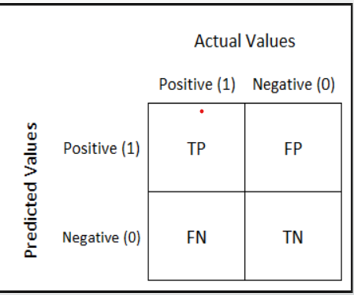

In [10]:
# Test function

TP,FP,FN,TN = calc_TP_FP_FN_TN(y_test, y_pred_test)
print("True positive  : ",TP , "False positive : ",FP)
print("False negative : ",FN , "True negative  : ",TN)

True positive  :  27 False positive :  7
False negative :  12 True negative  :  30


In [11]:
y_predict = clf.predict(x_test)
confusion_matrix(y_test,y_predict)

array([[30,  7],
       [12, 27]], dtype=int64)

In [13]:
# Calculate true positive rate and false positive rate
tpr,fpr = calc_TP_FP_rate(TP,FP,FN,TN)

print("True positive rate  : ",tpr)  ## 69%
print("False positive rate  : ",fpr)  ## 18%

True positive rate  :  0.6923076923076923
False positive rate  :  0.1891891891891892


In [15]:
fpr, tpr, threshold = roc_curve(y_test , y_predict)
auc = roc_auc_score(y_test , y_predict)

print("True positive rate  : ",tpr[1])
print("False positive rate  : ",fpr[1])

True positive rate  :  0.6923076923076923
False positive rate  :  0.1891891891891892


In [16]:
print(classification_report(y_test , y_predict))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76        37
           1       0.79      0.69      0.74        39

    accuracy                           0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.76      0.75      0.75        76



## Now we are going to find the threshold by plotting a ROC curve

### LOGISTIC REGRESSION (NO REGULARIZATION)

In [17]:
X = df.drop('target', axis=1)
y = df.target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=56)

In [18]:
# Fit and predict test class probabilities
lr = LogisticRegression(max_iter=1000, penalty='none')
lr.fit(x_train, y_train)

sample_df = pd.DataFrame(lr.predict_proba(x_test) , 
    columns = ['Probability of occuring 0 [Neagative review]' ,
               'Probability of occuring 1 [Positive review]' ])
sample_df.head()

,Probability of occuring 0 [Neagative review],Probability of occuring 1 [Positive review]
0,0.177719,0.822281
1,0.899451,0.100549
2,0.189678,0.810322
3,0.946519,0.053481
4,0.030499,0.969501


In [24]:
## I am taking only the probability of occuring 1 (i.e positive reviews)
y_test_probability = lr.predict_proba(x_test)[:,1] 

In [25]:
# Containers for true positive / false positive rates
#lr_tp_rates = lr_fp_rates = []

lr_tp_rates = []
lr_fp_rates = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

In [26]:
# Find true positive / false positive rate for each threshold
for i in probability_thresholds:
    y_test_predict = []
    
    for j in y_test_probability:  ## with the probabilities going into the probabilities 
        
        ## probability greater than the threshold
        if j>i:  y_test_predict.append(1)    ## positive review
            
        ## probability lesser than the threshold
        else  :  y_test_predict.append(0)    ## negative review
        
    TP,FP,FN,TN = calc_TP_FP_FN_TN(y_test, y_test_predict)
    tpr,fpr     = calc_TP_FP_rate(TP,FP,FN,TN)
    
    lr_tp_rates.append(tpr)
    lr_fp_rates.append(fpr)

In [27]:
pd.DataFrame({
    'threshold' : probability_thresholds,
    'True positive rate' : lr_tp_rates,
    'False postitive rate' : lr_fp_rates
}).head()

,threshold,True positive rate,False postitive rate
0,0.000000,1.0,1.000000
1,0.010101,1.0,0.837838
2,0.020202,1.0,0.756757
3,0.030303,1.0,0.675676
4,0.040404,1.0,0.621622


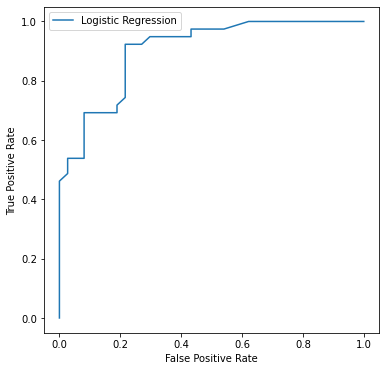

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(lr_fp_rates, lr_tp_rates, label='Logistic Regression')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend();

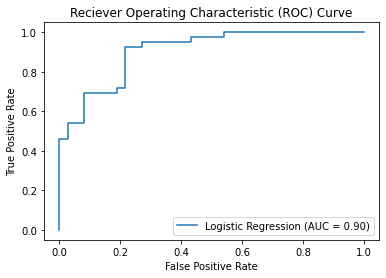

In [30]:
## via sklearn
plot_roc_curve(lr, x_test, y_test, name = 'Logistic Regression')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Reciever Operating Characteristic (ROC) Curve")

plt.legend()
plt.show()

In [31]:
print("Area Under the curve : ",roc_auc_score(y_test, y_test_probability))

Area Under the curve :  0.9043659043659044


### Logistic Regression (L2 regularization)

In [32]:
# Fit and predict test class probabilities
lr_2 = LogisticRegression(max_iter=1000, penalty='l2')
lr_2.fit(x_train, y_train)

sample_df = pd.DataFrame(lr_2.predict_proba(x_test) , 
    columns = ['Probability of occuring 0 [Neagative review]' ,
               'Probability of occuring 1 [Positive review]' ])
sample_df.head()

,Probability of occuring 0 [Neagative review],Probability of occuring 1 [Positive review]
0,0.172543,0.827457
1,0.877514,0.122486
2,0.207549,0.792451
3,0.931821,0.068179
4,0.055341,0.944659


In [33]:
## I am taking only the probability of occuring 1 (i.e positive reviews)
y_test_probability = lr_2.predict_proba(x_test)[:,1] 

In [34]:
# Containers for true positive / false positive rates
lr_2_tp_rates = []
lr_2_fp_rates = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

In [35]:
# Find true positive / false positive rate for each threshold
for i in probability_thresholds:
    y_test_predict = []
    
    for j in y_test_probability:  ## with the probabilities going into the probabilities 
        
        ## probability greater than the threshold
        if j>i:  y_test_predict.append(1)    ## positive review
            
        ## probability lesser than the threshold
        else  :  y_test_predict.append(0)    ## negative review
        
    TP,FP,FN,TN = calc_TP_FP_FN_TN(y_test, y_test_predict)
    tpr,fpr     = calc_TP_FP_rate(TP,FP,FN,TN)
    
    lr_2_tp_rates.append(tpr)
    lr_2_fp_rates.append(fpr)

In [36]:
pd.DataFrame({
    'threshold' : probability_thresholds,
    'True positive rate' : lr_2_tp_rates,
    'False postitive rate' : lr_2_fp_rates
}).head()


,threshold,True positive rate,False postitive rate
0,0.000000,1.0,1.000000
1,0.010101,1.0,0.891892
2,0.020202,1.0,0.810811
3,0.030303,1.0,0.783784
4,0.040404,1.0,0.702703


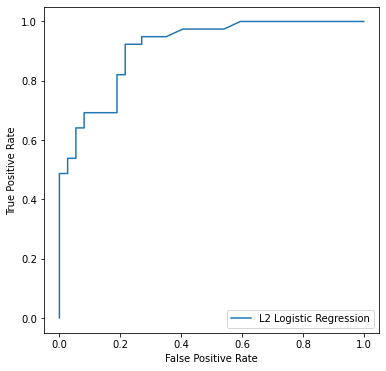

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(lr_2_fp_rates, lr_2_tp_rates, label='L2 Logistic Regression')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend();

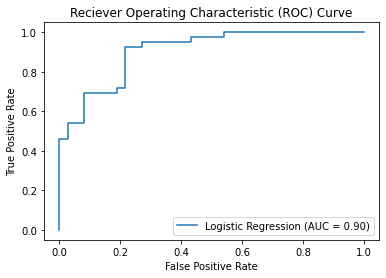

In [38]:
## via sklearn
plot_roc_curve(lr, x_test, y_test, name = 'Logistic Regression')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Reciever Operating Characteristic (ROC) Curve")

plt.legend()
plt.show()

In [40]:
print("Area Under the curve : ",roc_auc_score(y_test, y_test_probability))

Area Under the curve :  0.9112959112959113


### Combining both Normal Legularization and L2 Legularization

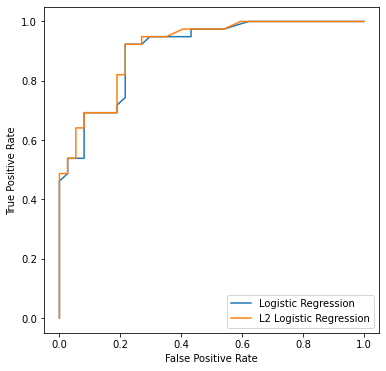

In [41]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(lr_fp_rates, lr_tp_rates,     label='Logistic Regression')
ax.plot(lr_2_fp_rates, lr_2_tp_rates, label='L2 Logistic Regression')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend();

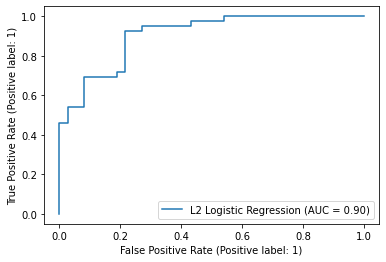

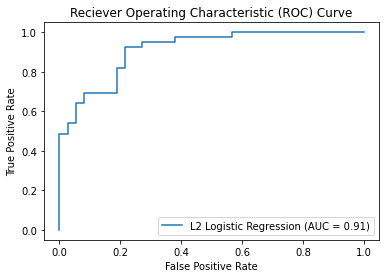

In [42]:
plot_roc_curve(lr, x_test, y_test, name = 'L2 Logistic Regression')
plot_roc_curve(lr_2, x_test, y_test, name = 'L2 Logistic Regression')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Reciever Operating Characteristic (ROC) Curve")

plt.legend()
plt.show()